In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

import matplotlib.pyplot as plt
import h5py
import os

from PIL import Image



# Configure Keras to use GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

2024-04-29 15:49:28.301206: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-29 15:49:28.335654: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 15:49:28.335684: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 15:49:28.336856: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-29 15:49:28.343639: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.ndimage import maximum_position, label
# def counting_filter_max(arr, threshold=20, structure=np.ones((3,3))):
#     """
#     Implements connected component analysis (CCA) on a single image to detect blobs,
#     then finds the maximum position within each blob to assign the entry positions.
    
#     Args:
#         arr: Numpy array representing an image, shape [H, W].
#         threshold: Threshold to convert the image to binary by filtering out dark noise.
#         structure: Structuring element for defining connectivity in the image.
    
#     Returns:
#         Numpy array of the same shape as `arr` where 1 indicates the maximum position of a blob,
#         and 0 elsewhere.
#     """
#     # Apply threshold to convert the image to a binary image
#     image_binary = arr > threshold

#     # Label connected components in the binary image
#     all_labels, num = label(image_binary, structure=structure)

#     # Find the maximum position within each labeled component
#     max_positions = maximum_position(arr, all_labels, range(1, num + 1))

#     # Create an output array to mark maximum positions
#     max_markers = np.zeros_like(arr)
#     max_markers[tuple(zip(*max_positions))] = 1

#     return max_markers

# # Generate a sample image (2D array)
# np.random.seed(0)
# sample_image = np.random.randint(0, 50, size=(10, 10))
# sample_image[3:5, 4:6] += 50  # Create a high intensity blob
# sample_image[7:9, 7:9] += 45  # Create another high intensity blob

# # Apply the counting_filter_max function
# result = counting_filter_max(sample_image, threshold=20)

# # Visualize the original image and the result
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.title("Original Image")
# plt.imshow(sample_image, cmap='gray')
# plt.colorbar()

# plt.subplot(1, 2, 2)
# plt.title("Max Positions Marked")
# plt.imshow(result, cmap='gray')
# plt.colorbar()

# plt.show()


In [20]:
# import numpy as np
# from scipy.ndimage import label

# def create_binary_mask(dimensions, boxes):
#     """
#     Create a binary mask from bounding boxes.
#     """
#     mask = np.zeros(dimensions, dtype=np.uint8)
#     for box in boxes:
#         x_min, y_min, x_max, y_max = box
#         mask[y_min:y_max, x_min:x_max] = 1
#     return mask

# def calculate_iou_components(pred_labels, gt_labels):
#     """
#     Calculate IoU for each predicted component against each ground truth component.
#     """
#     ious = []
#     pred_objects = np.unique(pred_labels)[1:]  # Exclude background
#     gt_objects = np.unique(gt_labels)[1:]  # Exclude background

#     for pred_obj in pred_objects:
#         pred_mask = pred_labels == pred_obj
#         for gt_obj in gt_objects:
#             gt_mask = gt_labels == gt_obj
#             intersection = np.logical_and(pred_mask, gt_mask)
#             union = np.logical_or(pred_mask, gt_mask)
#             iou = np.sum(intersection) / np.sum(union)
#             if iou > 0.5:  # Threshold to consider a match
#                 ious.append((pred_obj, gt_obj, iou))
#     return ious

# def evaluate_image(predictions, ground_truths, dimensions):
#     """
#     Evaluate a single image using precision, recall, and IoU.
#     """
#     pred_mask = create_binary_mask(dimensions, predictions)
#     gt_mask = create_binary_mask(dimensions, ground_truths)
    
#     pred_labels, num_pred = label(pred_mask)
#     gt_labels, num_gt = label(gt_mask)
    
#     ious = calculate_iou_components(pred_labels, gt_labels)
    
#     true_positives = len(ious)
#     predicted_positives = num_pred
#     actual_positives = num_gt
    
#     precision = true_positives / predicted_positives if predicted_positives else 0
#     recall = true_positives / actual_positives if actual_positives else 0
    
#     return {
#         'Precision': precision,
#         'Recall': recall,
#         'IoU Matches': ious
#     }
# import numpy as np

# def preprocess_boxes(boxes, image_shape):
#     """
#     Normalize and convert bounding box coordinates to integer values, adjusting for small values.
    
#     Args:
#         boxes: Array of bounding box coordinates.
#         image_shape: Tuple indicating the dimensions of the images (height, width).
    
#     Returns:
#         Processed boxes with integer coordinates.
#     """
#     height, width = image_shape
#     # Assuming boxes are normalized [x_min, y_min, x_max, y_max]
#     scaled_boxes = np.copy(boxes)
#     scaled_boxes[:, 0] *= width
#     scaled_boxes[:, 2] *= width
#     scaled_boxes[:, 1] *= height
#     scaled_boxes[:, 3] *= height

#     # Round to nearest integer and ensure minimum size of 1 for each dimension
#     scaled_boxes = np.rint(scaled_boxes).astype(int)
#     for box in scaled_boxes:
#         if box[2] == box[0]:  # Ensure minimum width
#             box[2] = box[0] + 1
#         if box[3] == box[1]:  # Ensure minimum height
#             box[3] = box[1] + 1

#     return scaled_boxes

# def filter_boxes(boxes):
#     """
#     Remove zero-sized or invalid boxes from the array.
    
#     Args:
#         boxes: Array of bounding box coordinates.
    
#     Returns:
#         Filtered array of bounding boxes.
#     """
#     filtered_boxes = [box for box in boxes if (box[2] > box[0] and box[3] > box[1])]
#     return np.array(filtered_boxes)

# # Mock dimensions of your images, e.g., 100x100 pixels
# image_dimensions = (64, 64)

# # Example usage
# predictions_raw = np.array([[2.9063843e+01, 5.6825363e+01, 3.0376661e+01, 5.7323868e+01],
#        [6.1131519e-01, 6.1410499e-01, 6.3220149e-01, 6.1376023e-01],
#        [3.8116515e-01, 5.8919060e-01, 4.2811164e-01, 6.5443587e-01],
#          [5.5959210e-04, 5.3034216e-04, 6.7056349e-04, 9.3700440e-04],
#          [5.9041078e-04, 6.1910786e-04, 8.5616822e-04, 3.2623659e-04],
#          [5.2420807e-04, 9.7561674e-04, 3.4557586e-04, 1.4522944e-03],
#           [5.5959210e-04, 5.3034216e-04, 6.7056349e-04, 9.3700440e-04],
#          [5.9041078e-04, 6.1910786e-04, 8.5616822e-04, 3.2623659e-04],
#          [5.2420807e-04, 9.7561674e-04, 3.4557586e-04, 1.4522944e-03],
#           [5.5959210e-04, 5.3034216e-04, 6.7056349e-04, 9.3700440e-04],
#          [5.9041078e-04, 6.1910786e-04, 8.5616822e-04, 3.2623659e-04],
#          [5.2420807e-04, 9.7561674e-04, 3.4557586e-04, 1.4522944e-03],# Your prediction array here
#        [5.5959210e-04, 5.3034216e-04, 6.7056349e-04, 9.3700440e-04],
#        [5.9041078e-04, 6.1910786e-04, 8.5616822e-04, 3.2623659e-04],
#        [5.2420807e-04, 9.7561674e-04, 3.4557586e-04, 1.4522944e-03]])  # Your prediction array here
# ground_truths_raw = np.array([[29., 57., 30., 57.],
#        [ 0.,  0.,  0.,  0.],
#        [ 0.,  0.,  0.,  0.],
#          [ 0.,  0.,  0.,  0.],
#          [ 0.,  0.,  0.,  0.],
#          [ 0.,  0.,  0.,  0.],
#           [ 0.,  0.,  0.,  0.],
#          [ 0.,  0.,  0.,  0.],
#          [ 0.,  0.,  0.,  0.],
#           [ 0.,  0.,  0.,  0.],
#          [ 0.,  0.,  0.,  0.],
#          [ 0.,  0.,  0.,  0.],
#        [ 0.,  0.,  0.,  0.],
#        [ 0.,  0.,  0.,  0.],
#        [ 0.,  0.,  0.,  0.]])  # Your ground truth array here

# # Preprocess and filter the boxes
# predictions = preprocess_boxes(predictions_raw, image_dimensions)
# predictions = filter_boxes(predictions)

# ground_truths = preprocess_boxes(ground_truths_raw, image_dimensions)
# ground_truths = filter_boxes(ground_truths)

# # Now use predictions and ground_truths with the evaluate_image function
# result = evaluate_image(predictions, ground_truths, image_dimensions)
# print(result)



In [7]:
with h5py.File('TrainingData5zeroes.h5', 'r') as hdf:
    ls = list(hdf.keys())
    images = hdf.get('images')[7000:]
    boxes = hdf.get('boxes')[7000:]
    images = np.array(images)
    boxes = np.array(boxes)


image_normalized = (images + 1e-9) / 9.26
normalized_boxes = boxes / [1, 64, 64, 64, 64]

images_np = image_normalized

probabilities = np.array(normalized_boxes[:, :, :-4])
probabilities = tf.expand_dims(probabilities, axis=1)
boxes_np = np.array(normalized_boxes[:, :, 1:])
boxes_np = tf.expand_dims(boxes_np, axis=1)
batch_size = 128
dataset = tf.data.Dataset.from_tensor_slices((images_np, {'x_prob_reshape': probabilities, 'x_boxes_reshape': boxes_np}))
dataset = dataset.shuffle(buffer_size=10000).batch(batch_size)
# total_items = len(images_np)
# train_size = int(total_items * 0.9)
# test_size = total_items - train_size 

#     # Splitting the dataset
# train_dataset = dataset.take(train_size)
# test_dataset = dataset.skip(train_size)


# train_dataset = train_dataset.shuffle(buffer_size=train_size,reshuffle_each_iteration=True)
# train_dataset = train_dataset.batch(batch_size)
# test_dataset = test_dataset.batch(batch_size) 

In [8]:
loadmodel = tf.keras.models.load_model("/home/m3-learning/Documents/Research Data/Derrick's Object Detection/Models/M11overfittedmodel4variant.keras")
# loadmodel = tf.keras.models.load_model("/home/m3-learning/Documents/Research Data/Derrick's Object Detection/Models/Sweep Weights/Train and Val/northern-sweep-1.h5")

In [5]:
# import numpy as np

# # Provided data
# predictions_raw = np.array([
#     [39.8903408, 24.773323, 39.454777, 25.82823],
#     [0.40461713, 0.2488891, 0.44437495, 0.2451111],
#     [0.4801518, 0.56913036, 0.52614892, 0.60166949],
#     [0.00044191495, 0.0005460676, 0.00068218674, 0.00090827933],
#     [0.00040864121, 0.00038058122, 0.00060208299, 0.00024521281],
#     [0.00052764977, 0.00058524718, 0.0002075122, 0.0010586288]
# ])

# ground_truth_raw = np.array([
#     [39, 24, 39, 25],
#     [0, 0, 0, 0],
#     [0, 0, 0, 0],
#     [0, 0, 0, 0],
#     [0, 0, 0, 0],
#     [0, 0, 0, 0]
# ])

# # Thresholds
# prediction_thresholds = np.where(np.max(predictions_raw, axis=0) > 1, 30, 0.5)  # Large values get higher threshold
# difference_thresholds = np.where(np.max(ground_truth_raw, axis=0) > 1, 1, 0.1)  # Large values get higher threshold

# # Normalized predictions (binary classification)
# predicted_classes = np.where(predictions_raw > prediction_thresholds, 1, 0)

# # Absolute difference
# abs_diff = np.abs(predictions_raw - ground_truth_raw)

# # Applying difference threshold
# is_close_enough = abs_diff <= difference_thresholds

# # Classifying true positives, false positives, true negatives, false negatives
# TP = (predicted_classes == 1) & is_close_enough
# FP = (predicted_classes == 1) & ~is_close_enough
# TN = (predicted_classes == 0) & is_close_enough
# FN = (predicted_classes == 0) & ~is_close_enough

# # Counting the classifications
# TP_count = np.sum(TP)
# FP_count = np.sum(FP)
# TN_count = np.sum(TN)
# FN_count = np.sum(FN)

# TP_count, FP_count, TN_count, FN_count


In [14]:

# dataset = tf.data.Dataset.from_tensor_slices((images_np,{'x_prob_reshape':probabilities,'x_boxes_reshape':boxes_np}))
# dataset = dataset.batch(10)
# # test_dataset = dataset.skip(train_size)
# # # test_dataset = test_dataset.shuffle(buffer_size=10000,reshuffle_each_iteration=True)
# # test_dataset = test_dataset.batch(test_size)
# # train_dataset = dataset.take(train_size)
# # # train_dataset = train_dataset.shuffle(buffer_size=10000,reshuffle_each_iteration=True)
# # train_dataset = train_dataset.batch(train_size)
# inputs,targets = next(iter(dataset))
# output =loadmodel.predict(inputs)

1/1 [==============================] - 0s 260ms/step


In [12]:
# import numpy as np
# import tensorflow as tf

# # Load the trained model
# # model = tf.keras.models.load_model('path_to_your_saved_model')

# # Assuming 'images_np', 'probabilities', and 'boxes_np' are your numpy arrays ready to be used
# dataset = tf.data.Dataset.from_tensor_slices((images_np, {'x_prob_reshape': probabilities, 'x_boxes_reshape': boxes_np}))
# dataset = dataset.batch(1000)  # Adjust the batch size according to your needs
# inputs, targets = next(iter(dataset))

# # Predict using the loaded model
# output = loadmodel.predict(inputs)

# # Define thresholds
# prediction_thresholds = np.array([0.5] * output[0].shape[1])  # Adjust this according to your output dimensions and scale
# difference_thresholds = np.array([0.1] * output[1].shape[1])  # Adjust this according to what you consider a close enough prediction

# # Evaluate predictions function (as previously defined)
# def evaluate_predictions(y_true, y_pred, pred_thresh, diff_thresh):
#     predicted_classes = (y_pred > pred_thresh).astype(int)
#     abs_diff = np.abs(y_pred - y_true)
#     is_close_enough = abs_diff <= diff_thresh

#     TP = np.logical_and(predicted_classes == 1, is_close_enough)
#     FP = np.logical_and(predicted_classes == 1, np.logical_not(is_close_enough))
#     TN = np.logical_and(predicted_classes == 0, is_close_enough)
#     FN = np.logical_and(predicted_classes == 0, np.logical_not(is_close_enough))

#     return np.sum(TP), np.sum(FP), np.sum(TN), np.sum(FN)

# # Assuming 'targets' dictionary contains arrays that match keys with 'output' dictionary keys
# total_TP = total_FP = total_TN = total_FN = 0

# TP, FP, TN, FN = evaluate_predictions(boxes_np.numpy(), output[1], prediction_thresholds, difference_thresholds)
# total_TP += TP
# total_FP += FP
# total_TN += TN
# total_FN += FN

# # Calculate precision and recall
# precision = total_TP / (total_TP + total_FP) if (total_TP + total_FP) > 0 else 0
# recall = total_TP / (total_TP + total_FN) if (total_TP + total_FN) > 0 else 0

# print(f'Precision: {precision}, Recall: {recall}')


Conversion From Regression to Classification

In [9]:
import numpy as np
import tensorflow as tf

# Assuming you have loaded the model and the dataset
dataset = tf.data.Dataset.from_tensor_slices((images_np, {'x_prob_reshape': probabilities, 'x_boxes_reshape': boxes_np}))
dataset = dataset.batch(301)  # Adjust the batch size according to your needs
inputs, targets = next(iter(dataset))

# Predict using the loaded model
output = loadmodel.predict(inputs)

# Define thresholds
# prediction_thresholds = np.array([0.4] * output[1].shape[1])  # Adjust this according to your output dimensions and scale
# difference_thresholds = np.array([0.1] * output[1].shape[1])  # Adjust this according to what you consider a close enough prediction
prediction_thresholds = np.array([0.5, 0.5, 0.5, 0.5])
difference_thresholds = np.array([0.1, 0.1, 0.1, 0.1])

# # Evaluate predictions function (as previously defined)
# def evaluate_predictions(y_true, y_pred, pred_thresh, diff_thresh):
#     predicted_classes = (y_pred > pred_thresh).astype(int)
#     abs_diff = np.abs(y_pred - y_true)
#     is_close_enough = abs_diff <= diff_thresh

#     TP = np.logical_and(predicted_classes == 1, is_close_enough)
#     FP = np.logical_and(predicted_classes == 1, np.logical_not(is_close_enough))
#     TN = np.logical_and(predicted_classes == 0, is_close_enough)
#     FN = np.logical_and(predicted_classes == 0, np.logical_not(is_close_enough))

#     return np.sum(TP), np.sum(FP), np.sum(TN), np.sum(FN)


import numpy as np

def evaluate_predictions(y_true, y_pred, pred_thresh, diff_thresh):
    predicted_classes = (y_pred > pred_thresh).astype(int)
    abs_diff = np.abs(y_pred - y_true)
    is_close_enough = abs_diff <= diff_thresh
    
    # True Positive: All coordinates must be close enough in a positively predicted sample
    TP = (predicted_classes == 1) & np.all(is_close_enough, axis=1)
    
    # False Positive: Any coordinate not close enough in a positively predicted sample
    FP = (predicted_classes == 1) & ~np.all(is_close_enough, axis=1)
    
    # True Negative: Predicted as negative (no need to check closeness)
    TN = (predicted_classes == 0)
    
    # False Negative: Predicted as negative but should have been positive (based on prediction threshold alone)
    FN = (predicted_classes == 0) & (y_true > pred_thresh).any(axis=1)
    
    return np.sum(TP), np.sum(FP), np.sum(TN), np.sum(FN)


# Assuming 'targets' dictionary contains arrays that match keys with 'output' dictionary keys
total_TP = total_FP = total_TN = total_FN = 0

TP, FP, TN, FN = evaluate_predictions(targets['x_boxes_reshape'].numpy(), output[1], prediction_thresholds, difference_thresholds)
total_TP += TP
total_FP += FP
total_TN += TN
total_FN += FN

# Calculate precision and recall
precision = total_TP / (total_TP + total_FP) if (total_TP + total_FP) > 0 else 0
recall = total_TP / (total_TP + total_FN) if (total_TP + total_FN) > 0 else 0

# Calculate F1 score
if (precision + recall) > 0:
    f1_score = 2 * (precision * recall) / (precision + recall)
else:
    f1_score = 0

print(f'Precision: {precision}, Recall: {recall}, F1 Score: {f1_score}')


10/10 [==============================] - 0s 8ms/step
Precision: 0.8820072711959346, Recall: 0.5789277967271784, F1 Score: 0.6990297343422884


In [11]:
output[1][8]*64,targets['x_boxes_reshape'][8]*64

(array([[[5.6570011e+01, 4.6470253e+01, 5.7031590e+01, 4.7806549e+01],
         [2.8592041e+01, 5.9081009e+01, 2.9590895e+01, 5.9466404e+01],
         [2.8545412e+01, 1.3803929e+01, 3.0624582e+01, 1.4750621e+01],
         ...,
         [2.1487900e-05, 2.0288535e-05, 6.7233683e-05, 5.6221626e-05],
         [2.9877892e-05, 1.9206125e-05, 4.9760987e-05, 1.4272087e-05],
         [2.0359243e-05, 2.2661616e-05, 1.9187488e-05, 4.3200002e-05]]],
       dtype=float32),
 <tf.Tensor: shape=(1, 280, 4), dtype=float64, numpy=
 array([[[58., 48., 58., 49.],
         [36., 60., 37., 61.],
         [22., 11., 23., 11.],
         ...,
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.]]])>)

Mean IoU: 0.06961929567127564, Mean MAE: 0.39206414480663165


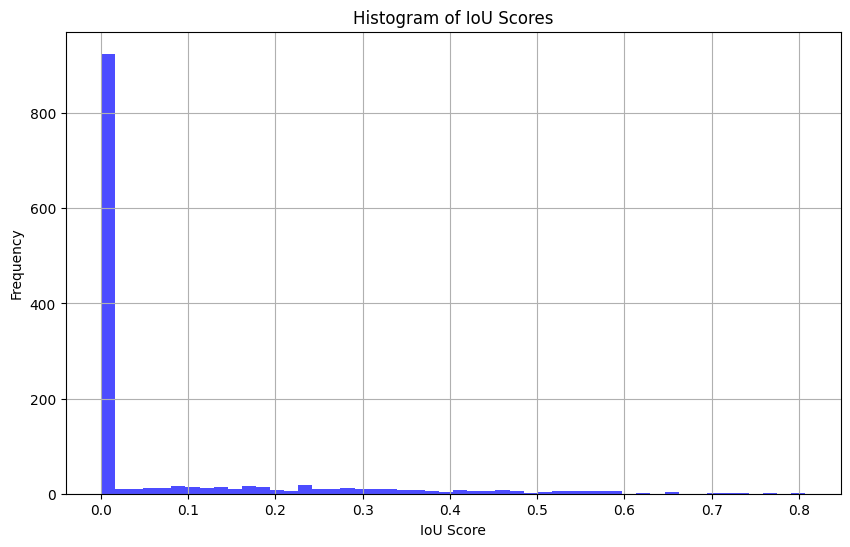

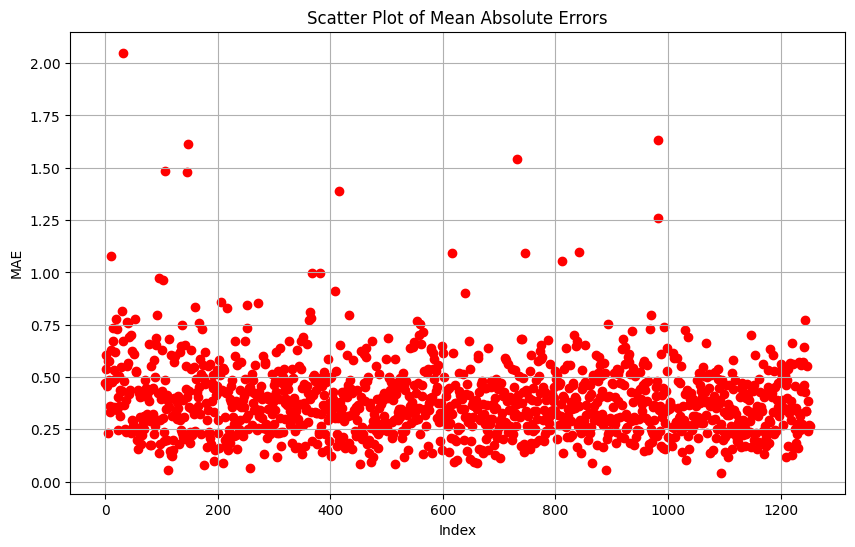

In [6]:
# def compute_iou(box1, box2):
#     y_top = max(box1[1], box2[1])
#     x_left = max(box1[0], box2[0])
#     y_bottom = min(box1[3], box2[3])
#     x_right = min(box1[2], box2[2])

#     if x_right < x_left or y_bottom < y_top:
#         return 0.0

#     intersection_area = (x_right - x_left) * (y_bottom - y_top)
#     box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
#     box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
#     union_area = box1_area + box2_area - intersection_area
#     iou = intersection_area / union_area
#     return iou

def compute_iou(box1, box2):
    """
    Compute the Intersection over Union (IoU) of two bounding boxes.

    Parameters:
    - box1, box2: (xmin, ymin, xmax, ymax)

    Returns:
    - iou: Intersection over Union (float)
    """
    # Determine the coordinates of the intersection rectangle
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # Calculate intersection area
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # Calculate the union area
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - intersection_area

    # Compute the IoU
    iou = intersection_area / union_area
    return iou


def compute_mae(box1, box2):
    return np.mean(np.abs(np.array(box1) - np.array(box2)))

iou_scores = []
mae_scores = []

# Iterate through each batch item
for batch_index in range(targets['x_boxes_reshape'].shape[0]):
    for box_index in range(targets['x_boxes_reshape'].shape[2]):  # Assuming 280 boxes per image
        true_box = targets['x_boxes_reshape'][batch_index, 0, box_index]*64
        pred_box = output[1][batch_index, 0, box_index]*64
        
        # Compute IoU and MAE only for boxes that are not all zeros
        if not np.all(true_box == 0) and not np.all(pred_box == 0):
            iou_score = compute_iou(true_box, pred_box)
            mae_score = compute_mae(true_box, pred_box)
            iou_scores.append(iou_score)
            mae_scores.append(mae_score)

# Continue with your existing summary statistics and visualization code
mean_iou = np.mean(iou_scores)
mean_mae = np.mean(mae_scores)
print(f"Mean IoU: {mean_iou}, Mean MAE: {mean_mae}")

import matplotlib.pyplot as plt

# Histogram of IoU Scores
plt.figure(figsize=(10, 6))
plt.hist(iou_scores, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of IoU Scores')
plt.xlabel('IoU Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Scatter Plot of MAE
plt.figure(figsize=(10, 6))
plt.scatter(range(len(mae_scores)), mae_scores, color='red')
plt.title('Scatter Plot of Mean Absolute Errors')
plt.xlabel('Index')
plt.ylabel('MAE')
plt.grid(True)
plt.show()


In [10]:
import numpy as np

# def load_data(file_path):
#     data = np.load(file_path)
#     return data['result'], data['mae'], data['dce'], data['recall'], data['precision'], data['deviations'], data['dce_corrected']

def load_data(file_path):
    """
    Load data from an NPZ file.
    """
    with np.load(file_path, allow_pickle=True) as data:
        result = data['result']
        mae = data['mae']
        dce = data['dce']
        recall = data['recall']
        precision = data['precision']
        deviations = data['deviations']
        dce_corrected = data['dce_corrected']
    return result, mae, dce, recall, precision, deviations, dce_corrected

# Metric Calculation Functions
def calculate_mae(filtered, ground_truth):
    return np.mean(np.abs(filtered - ground_truth))

def calculate_precision(tp, fp):
    return tp / (tp + fp) if (tp + fp) > 0 else 0

def calculate_recall(tp, fn):
    return tp / (tp + fn) if (tp + fn) > 0 else 0

def calculate_dce(detected_count, actual_count):
    return detected_count / actual_count if actual_count > 0 else 0

def calculate_corrected_dce(deviations, actual_count):
    valid_detections = len([d for d in deviations if d <= 6])  # Example threshold
    return valid_detections / actual_count if actual_count > 0 else 0

# Process data and calculate metrics
# def process_data(file_path):
#     predictions, ground_truth = load_data(file_path)
#     metrics = {'mae': [], 'precision': [], 'recall': [], 'dce': [], 'corrected_dce': []}
    
#     for i in range(predictions.shape[0]):
#         filtered = predictions[i]
#         truth = ground_truth[i]

#         tp = np.sum((filtered > 0) & (truth > 0))
#         fp = np.sum((filtered > 0) & (truth == 0))
#         fn = np.sum((filtered == 0) & (truth > 0))
#         detected_count = np.sum(filtered > 0)
#         actual_count = np.sum(truth > 0)

#         mae = calculate_mae(filtered, truth)
#         precision = calculate_precision(tp, fp)
#         recall = calculate_recall(tp, fn)
#         dce = calculate_dce(detected_count, actual_count)
#         deviations = np.random.uniform(0, 10, size=tp)  # Example deviations, replace with actual
#         corrected_dce = calculate_corrected_dce(deviations, actual_count)

#         metrics['mae'].append(mae)
#         metrics['precision'].append(precision)
#         metrics['recall'].append(recall)
#         metrics['dce'].append(dce)
#         metrics['corrected_dce'].append(corrected_dce)

#     # Calculate average metrics
#     for key in metrics:
#         metrics[key] = np.mean(metrics[key])

#     return metrics

# # Example usage
# file_path = '/home/m3-learning/Documents/myML/ValidationResults/Stack001_result.npz'
# results = process_data(file_path)
# print(results)

# def process_data(file_path):
#     # Load data
#     result, mae, dce, recall, precision, deviations, dce_corrected = load_data(file_path)

#     # Convert to numpy arrays if they are not already
#     mae = np.array(mae)
#     dce = np.array(dce)
#     recall = np.array(recall)
#     precision = np.array(precision)
#     dce_corrected = np.array(dce_corrected)

#     # Calculate average metrics
#     metrics = {
#         'Average MAE': np.mean(mae),
#         'Average DCE': np.mean(dce),
#         'Average Recall': np.mean(recall),
#         'Average Precision': np.mean(precision),
#         'Average Corrected DCE': np.mean(dce_corrected)
#     }

#     return metrics

# Example usage
# file_path = '/home/m3-learning/Documents/myML/ValidationResults/Stack001_result.npz'
# results = process_data(file_path)
# print("Aggregated Metrics:", results)

# def process_data(file_path):
#     """
#     Process the loaded data to calculate average metrics.
#     """
#     # Load results and metrics from the file
#     result, mae, dce, recall, precision, deviations, dce_corrected = load_data(file_path)

#     # Calculate average of each metric
#     metrics = {
#         'Average MAE': np.mean(mae),
#         'Average DCE': np.mean(dce),
#         'Average Recall': np.mean(recall),
#         'Average Precision': np.mean(precision),
#         'Average Corrected DCE': np.mean(dce_corrected)
#     }

#     return metrics

# def print_results(metrics):
#     """
#     Print the calculated average metrics.
#     """
#     for metric_name, average_value in metrics.items():
#         print(f"{metric_name}: {average_value:.4f}")

# # Main function to run the script
# def main():
#     file_path = '/home/m3-learning/Documents/myML/ValidationData-20231107T163458Z-001/ValidationData/Stack007.npz'  # Update this to your actual file path
#     results = process_data(file_path)
#     print_results(results)

# if __name__ == "__main__":
#     main()

KeyError: 'result is not a file in the archive'

In [27]:
# def compute_iou(box1, box2):
#     """
#     Compute the Intersection over Union (IoU) of two bounding boxes.

#     Parameters:
#     - box1, box2: (ymin, xmin, ymax, xmax)

#     Returns:
#     - iou: Intersection over Union (float)
#     """
#     # Determine the coordinates of the intersection rectangle
#     y_top = max(box1[0], box2[0])
#     x_left = max(box1[1], box2[1])
#     y_bottom = min(box1[2], box2[2])
#     x_right = min(box1[3], box2[3])

#     if x_right < x_left or y_bottom < y_top:
#         return 0.0

#     # Calculate intersection area
#     intersection_area = (x_right - x_left) * (y_bottom - y_top)

#     # Calculate the union area
#     box1_area = (box1[3] - box1[1]) * (box1[2] - box1[0])
#     box2_area = (box2[3] - box2[1]) * (box2[2] - box2[0])
#     union_area = box1_area + box2_area - intersection_area

#     # Compute the IoU
#     iou = intersection_area / union_area
#     return iou

# import numpy as np

# # Convert TensorFlow tensors to numpy arrays if they are not already
# true_boxes = targets['x_boxes_reshape'].numpy() if isinstance(targets['x_boxes_reshape'], tf.Tensor) else targets['x_boxes_reshape']
# predicted_boxes = output[1].numpy() if isinstance(output[1], tf.Tensor) else output[1]

# iou_scores = []
# mae_scores = []

# for true_box, pred_box in zip(true_boxes, predicted_boxes):
#     iou_score = compute_iou(true_box, pred_box)
#     mae_score = compute_mae(true_box, pred_box)
#     iou_scores.append(iou_score)
#     mae_scores.append(mae_score)

# # Calculate binary classification based on IoU threshold
# good_predictions = [iou >= iou_threshold for iou in iou_scores]

# # Calculate model performance based on IoU threshold
# TP = sum(good_predictions)
# FP = len(good_predictions) - TP  # In this context, all non-TP are treated as FP, which is simplistic

# precision = TP / (TP + FP) if (TP + FP) > 0 else 0
# recall = TP / len(good_predictions) if len(good_predictions) > 0 else 0
# f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
# mean_mae = np.mean(mae_scores)

# print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1_score}, Mean MAE: {mean_mae}")


In [28]:
# import numpy as np
# import tensorflow as tf
# import matplotlib.pyplot as plt

# # Assuming 'model' is your trained model and 'dataset' is prepared
# for inputs, true_labels in dataset.take(1):  # Adjust this as necessary to process more of your data
#     predictions = loadmodel.predict(inputs)

#     # Convert predictions to a numpy array if it's not already one
#     if isinstance(predictions, list):
#         # Assuming you want to work with the first set of predictions if there are multiple outputs
#         predictions = predictions[1]

#     # Convert to numpy array if necessary
#     predictions = np.array(predictions)

#     # Apply threshold to classify as binary labels
#     predicted_labels = (predictions > 0.5).astype(int)  # Assuming binary classification

# # Calculate the confusion matrix
# conf_matrix = tf.math.confusion_matrix(
#     np.ravel(true_labels['x_boxes_reshape']),  # Ensure true_labels are also a numpy array
#     np.ravel(predicted_labels[1]),  # Flatten the predicted labels
#     num_classes=2  # Adjust this based on the number of classes in your model
# )

# # Convert to numpy array (optional, for easier manipulation)
# conf_matrix = conf_matrix.numpy()

# # Function to plot the confusion matrix
# def plot_confusion_matrix(cm, class_names):
#     """
#     Returns a matplotlib figure containing the plotted confusion matrix.
    
#     Args:
#       cm (array, shape = [n, n]): a confusion matrix of integer classes
#       class_names (array, shape = [n]): String names of the integer classes
#     """
#     figure = plt.figure(figsize=(8, 8))
#     plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
#     plt.title("Confusion Matrix")
#     plt.colorbar()
#     tick_marks = np.arange(len(class_names))
#     plt.xticks(tick_marks, class_names, rotation=45)
#     plt.yticks(tick_marks, class_names)

#     # Normalize the confusion matrix.
#     cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

#     # Use white text if squares are dark; black text if squares are light.
#     threshold = cm.max() / 2.
#     for i, j in np.ndindex(cm.shape):
#         color = "white" if cm[i, j] > threshold else "black"
#         plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     return figure

# # Assuming class names are 'Negative' and 'Positive' for a binary classification
# class_names = ['Negative', 'Positive']
# plot_confusion_matrix(conf_matrix, class_names)
# plt.show()


In [24]:
# import numpy as np
# import tensorflow as tf


# import numpy as np
# from scipy.ndimage import label

# def create_binary_mask(dimensions, boxes):
#     """
#     Create a binary mask from bounding boxes.
#     """
#     mask = np.zeros(dimensions, dtype=np.uint8)
#     for box in boxes:
#         x_min, y_min, x_max, y_max = box
#         mask[y_min:y_max, x_min:x_max] = 1
#     return mask

# def calculate_iou_components(pred_labels, gt_labels):
#     """
#     Calculate IoU for each predicted component against each ground truth component.
#     """
#     ious = []
#     pred_objects = np.unique(pred_labels)[1:]  # Exclude background
#     gt_objects = np.unique(gt_labels)[1:]  # Exclude background

#     for pred_obj in pred_objects:
#         pred_mask = pred_labels == pred_obj
#         for gt_obj in gt_objects:
#             gt_mask = gt_labels == gt_obj
#             intersection = np.logical_and(pred_mask, gt_mask)
#             union = np.logical_or(pred_mask, gt_mask)
#             iou = np.sum(intersection) / np.sum(union)
#             if iou > 0.5:  # Threshold to consider a match
#                 ious.append((pred_obj, gt_obj, iou))
#     return ious

# def evaluate_image(predictions, ground_truths, dimensions):
#     """
#     Evaluate a single image using precision, recall, and IoU.
#     """
#     pred_mask = create_binary_mask(dimensions, predictions)
#     gt_mask = create_binary_mask(dimensions, ground_truths)
    
#     pred_labels, num_pred = label(pred_mask)
#     gt_labels, num_gt = label(gt_mask)
    
#     ious = calculate_iou_components(pred_labels, gt_labels)
    
#     true_positives = len(ious)
#     predicted_positives = num_pred
#     actual_positives = num_gt
    
#     precision = true_positives / predicted_positives if predicted_positives else 0
#     recall = true_positives / actual_positives if actual_positives else 0
    
#     return {
#         'Precision': precision,
#         'Recall': recall,
#         'IoU Matches': ious
#     }


In [23]:
    
# import numpy as np



# def filter_boxes(boxes):
#     """
#     Remove zero-sized or invalid boxes from the array.
    
#     Args:
#         boxes: Array of bounding box coordinates.
    
#     Returns:
#         Filtered array of bounding boxes.
#     """
#     filtered_boxes = [box for box in boxes if (box[2] > box[0] and box[3] > box[1])]
#     return np.array(filtered_boxes)



# # def preprocess_and_evaluate(dataset, model, image_dimensions):
# #     """
# #     Process and evaluate the dataset using the provided deep learning model.
    
# #     Args:
# #         dataset: A tf.data.Dataset object.
# #         model: A trained model that outputs predictions.
# #         image_dimensions: Dimensions of the images in the dataset (height, width).
    
# #     Returns:
# #         A list of evaluation results for each image in the dataset.
# #     """
# #     results = []
# #     for inputs, targets in dataset:
# #         # Predict using the trained model
# #         dataset = tf.data.Dataset.from_tensor_slices((images_np,{'x_prob_reshape':probabilities,'x_boxes_reshape':boxes_np}))
# #         dataset = dataset.batch(10000)
# #         inputs,targets = next(iter(dataset))
        
# #         predictions = model.predict(inputs)
        
# #         # Assuming predictions are already decoded to bounding boxes
# #         # If not, you will need to convert the raw model outputs to bounding boxes
# #         predicted_boxes = predictions[1]

# #         # Ground truth boxes
# #         ground_truth_boxes = targets['x_boxes_reshape'].numpy()

# #         # Preprocess predicted and ground truth boxes
# #         predictions_processed = preprocess_boxes(predicted_boxes, image_dimensions)
# #         ground_truths_processed = preprocess_boxes(ground_truth_boxes, image_dimensions)

# #         # Filter out invalid boxes
# #         predictions_filtered = filter_boxes(predictions_processed)
# #         ground_truths_filtered = filter_boxes(ground_truths_processed)

# #         # Evaluate
# #         result = evaluate_image(predictions_filtered, ground_truths_filtered, image_dimensions)
# #         results.append(result)

# #     return results

# # # Usage Example
# # # Define image dimensions based on your dataset specifics
# # image_dimensions = (64, 64)  # Update with your actual image dimensions
# # results = preprocess_and_evaluate(dataset, loadmodel, image_dimensions)

# # for result in results:
# #     print(result)
# # import numpy as np
# # import tensorflow as tf

# def preprocess_boxes(boxes, image_dimensions):
#     """
#     Normalize and convert bounding box coordinates to integer values, adjusting for small values.
#     """
#     print("Preprocessing boxes with initial shape:", boxes.shape)
#     height, width = image_dimensions
#     scaled_boxes = np.copy(boxes)
#     scaled_boxes[:, 0] *= width
#     scaled_boxes[:, 1] *= height
#     scaled_boxes[:, 2] *= width
#     scaled_boxes[:, 3] *= height

#     scaled_boxes = np.rint(scaled_boxes).astype(int)
#     for box in scaled_boxes:
#         if box[2] == box[0]:  # Ensure minimum width
#             box[2] = box[0] + 1
#         if box[3] == box[1]:  # Ensure minimum height
#             box[3] = box[1] + 1
#     return scaled_boxes

# # def preprocess_and_evaluate(dataset, model, image_dimensions):
# #     """
# #     Process and evaluate the dataset using the provided deep learning model.
# #     """
# #     results = []
# #     for inputs, targets in dataset:
# #         predictions = model.predict(inputs)
        
# #         # Debugging output
# #         print("Predictions shape:", predictions[1].shape)
# #         print("Ground truth shape:", targets['x_boxes_reshape'].numpy().shape)

# #         predicted_boxes = predictions[1]
# #         ground_truth_boxes = targets['x_boxes_reshape'].numpy()

# #         # Ensure boxes are correctly shaped
# #         if predicted_boxes.ndim < 2 or predicted_boxes.shape[1] != 4:
# #             raise ValueError("Predicted boxes are not in the expected format. Expected shape (n, 4).")

# #         predictions_processed = preprocess_boxes(predicted_boxes, image_dimensions)
# #         ground_truths_processed = preprocess_boxes(ground_truth_boxes, image_dimensions)

# #         predictions_filtered = filter_boxes(predictions_processed)
# #         ground_truths_filtered = filter_boxes(ground_truths_processed)

# #         result = evaluate_image(predictions_filtered, ground_truths_filtered, image_dimensions)
# #         results.append(result)

# #     return results

# # # Example usage
# # image_dimensions = (64, 64)  # Update with your actual image dimensions
# # results = preprocess_and_evaluate(dataset, loadmodel, image_dimensions)

# # for result in results:
# #     print(result)
# import numpy as np
# import tensorflow as tf

# def preprocess_and_evaluate(dataset, model, image_dimensions):
#     """
#     Process and evaluate the dataset using the provided deep learning model.
#     """
#     results = []
#     for inputs, targets in dataset:
#         predictions = model.predict(inputs)
        
#         # Debugging output to understand the structure of predictions
#         print("Predictions type:", type(predictions))
#         print("Predictions content:", predictions)

#         # Example assumes predictions to be a list or a similar structure
#         # Adjust the index according to your model's output structure
#         predicted_boxes = predictions[1] if isinstance(predictions, list) else predictions

#         ground_truth_boxes = targets['x_boxes_reshape'].numpy()

#         # More debugging output
#         print("Predicted Boxes Shape:", predicted_boxes.shape)
#         print("Ground Truth Boxes Shape:", ground_truth_boxes.shape)

#         # Check the dimensions and format
#         if predicted_boxes.ndim < 2 or predicted_boxes.shape[1] != 4:
#             raise ValueError("Predicted boxes are not in the expected format. Expected shape (n, 4).")

#         predictions_processed = preprocess_boxes(predicted_boxes, image_dimensions)
#         ground_truths_processed = preprocess_boxes(ground_truth_boxes, image_dimensions)

#         predictions_filtered = filter_boxes(predictions_processed)
#         ground_truths_filtered = filter_boxes(ground_truths_processed)

#         result = evaluate_image(predictions_filtered, ground_truths_filtered, image_dimensions)
#         results.append(result)

#     return results

# # Example usage
# image_dimensions = (64, 64)  # Update with your actual image dimensions
# results = preprocess_and_evaluate(dataset, loadmodel, image_dimensions)

# for result in results:
#     print(result)


In [5]:
# def correct_bboxes(bboxes):
#     """Ensure the bounding boxes are in the format [x_min, y_min, x_max, y_max] and have meaningful size."""
#     corrected = []
#     for bbox in bboxes:
#         sorted_x = sorted([bbox[0], bbox[2]])
#         sorted_y = sorted([bbox[1], bbox[3]])
#         x_min, x_max = sorted_x[0], sorted_x[1]
#         y_min, y_max = sorted_y[0], sorted_y[1]
#         # Check if all coordinates are >= 1 and dimensions are valid
#         if x_max > x_min + 1 and y_max > y_min + 1:
#             corrected.append([x_min, y_min, x_max, y_max])
#     return np.array(corrected)



# import numpy as np

# # Prediction and ground truth bounding boxes provided
# predictions_raw = np.array([
#     [39.8903408, 24.773323, 39.454777, 25.82823],
#     [0.40461713, 0.2488891, 0.44437495, 0.2451111],
#     [0.4801518, 0.56913036, 0.52614892, 0.60166949],
#     [0.00044191495, 0.0005460676, 0.00068218674, 0.00090827933],
#     [0.00040864121, 0.00038058122, 0.00060208299, 0.00024521281],
#     [0.00052764977, 0.00058524718, 0.0002075122, 0.0010586288]
# ])

# ground_truth_raw = np.array([
#     [39, 24, 39, 25],
#     [0, 0, 0, 0],
#     [0, 0, 0, 0],
#     [0, 0, 0, 0],
#     [0, 0, 0, 0],
#     [0, 0, 0, 0]
# ])

# def bbox_iou(box1, box2):
#     """Calculate the Intersection over Union (IoU) of two bounding boxes."""
#     x1, y1, x2, y2 = box1
#     x1_p, y1_p, x2_p, y2_p = box2
#     xi1, yi1 = max(x1, x1_p), max(y1, y1_p)
#     xi2, yi2 = min(x2, x2_p), min(y2, y2_p)
#     inter_area = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)
#     box1_area = (x2 - x1) * (y2 - y1)
#     box2_area = (x2_p - x1_p) * (y2_p - y1_p)
#     union_area = box1_area + box2_area - inter_area
#     return inter_area / union_area if union_area != 0 else 0

# def evaluate_metrics(gt_boxes, pred_boxes, iou_threshold=0.5):
#     """Evaluate detection metrics based on the IoU threshold."""
#     TP = 0
#     FP = 0
#     FN = 0
#     matched = []
#     for pred_box in pred_boxes:
#         match_found = False
#         for gt_box in gt_boxes:
#             if bbox_iou(pred_box, gt_box) >= iou_threshold:
#                 if gt_box not in matched:
#                     TP += 1
#                     matched.append(gt_box)
#                     match_found = True
#                     break
#         if not match_found:
#             FP += 1
#     FN = len(gt_boxes) - len(matched)
#     precision = TP / (TP + FP) if (TP + FP) > 0 else 0
#     recall = TP / (TP + FN) if (TP + FN) > 0 else 0
#     f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
#     return precision, recall, f1_score

# # Apply corrections
# predictions = correct_bboxes(predictions_raw)
# ground_truth = correct_bboxes(ground_truth_raw)

# # Calculate metrics
# precision, recall, f1_score = evaluate_metrics(ground_truth, predictions)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1-Score:", f1_score)


Precision: 0
Recall: 0
F1-Score: 0


In [16]:
# import numpy as np

# def prepare_bboxes(bboxes):
#     """Prepare bounding boxes by setting values less than 1 to zero."""
#     # Applying the threshold by setting values less than 1 to zero
#     bboxes[bboxes < 1] = 0
#     # Return only those boxes where no coordinate is zero
#     return bboxes[np.all(bboxes[:, [0, 2]] > 0, axis=1) & np.all(bboxes[:, [1, 3]] > 0, axis=1)]

# def create_binary_mask(bbox, shape):
#     """Create a binary mask from a bounding box."""
#     mask = np.zeros(shape, dtype=np.uint8)
#     if np.any(bbox > 0):  # Check if any value in bbox is greater than 0
#         x_min, y_min, x_max, y_max = map(int, bbox)
#         mask[y_min:y_max, x_min:x_max] = 1
#     return mask

# # Image dimensions (assuming 64x64 based on previous context)
# image_shape = (64, 64)

# # Example bounding boxes
# predictions_raw = np.array([
#     [39.8903408, 24.773323, 39.454777, 25.82823],
#     [0.40461713, 0.2488891, 0.44437495, 0.2451111],
#     [0.4801518, 0.56913036, 0.52614892, 0.60166949],
#     [0.00044191495, 0.0005460676, 0.00068218674, 0.00090827933],
#     [0.00040864121, 0.00038058122, 0.00060208299, 0.00024521281],
#     [0.00052764977, 0.00058524718, 0.0002075122, 0.0010586288]
# ])

# ground_truth_raw = np.array([
#     [39, 24, 39, 25],
#     [0, 0, 0, 0],
#     [0, 0, 0, 0],
#     [0, 0, 0, 0],
#     [0, 0, 0, 0],
#     [0, 0, 0, 0]
# ])

# # Filter and prepare bounding boxes
# filtered_predictions = prepare_bboxes(predictions_raw)
# filtered_ground_truth = prepare_bboxes(ground_truth_raw)

# # Create binary masks
# pred_masks = np.array([create_binary_mask(bbox, image_shape) for bbox in filtered_predictions])
# gt_masks = np.array([create_binary_mask(bbox, image_shape) for bbox in filtered_ground_truth])

# # Display number of masks created
# print("Number of Prediction Masks:", len(pred_masks))
# print("Number of Ground Truth Masks:", len(gt_masks))


Number of Prediction Masks: 1
Number of Ground Truth Masks: 1


In [ ]:
# import numpy as np

# def prepare_bboxes(bboxes):
#     """Prepare bounding boxes by setting values less than 1 to zero."""
#     # Applying the threshold by setting values less than 1 to zero
#     bboxes[bboxes < 1] = 0
#     # Return only those boxes where no coordinate is zero
#     return bboxes[np.all(bboxes[:, [0, 2]] > 0, axis=1) & np.all(bboxes[:, [1, 3]] > 0, axis=1)]


# # Image dimensions (assuming 64x64 based on previous context)
# image_shape = (64, 64)

# # Example bounding boxes
# predictions_raw = np.array([
#     [39.8903408, 24.773323, 39.454777, 25.82823],
#     [0.40461713, 0.2488891, 0.44437495, 0.2451111],
#     [0.4801518, 0.56913036, 0.52614892, 0.60166949],
#     [0.00044191495, 0.0005460676, 0.00068218674, 0.00090827933],
#     [0.00040864121, 0.00038058122, 0.00060208299, 0.00024521281],
#     [0.00052764977, 0.00058524718, 0.0002075122, 0.0010586288]
# ])

# ground_truth_raw = np.array([
#     [39, 24, 39, 25],
#     [0, 0, 0, 0],
#     [0, 0, 0, 0],
#     [0, 0, 0, 0],
#     [0, 0, 0, 0],
#     [0, 0, 0, 0]
# ])

# # Filter and prepare bounding boxes
# filtered_predictions = prepare_bboxes(predictions_raw)
# filtered_ground_truth = prepare_bboxes(ground_truth_raw)

# import numpy as np

# # Corrected bounding box values
# ground_truth = np.array([[38, 24, 40, 25]])
# predictions = np.array([[int(39.8903408), int(24.773323), int(39.454777)+1, int(25.82823)+1]])  # Added +1 to ensure non-zero area

# # Function to create binary masks
# def create_binary_mask(bbox, shape):
#     mask = np.zeros(shape, dtype=np.uint8)
#     mask[bbox[1]:bbox[3], bbox[0]:bbox[2]] = 1
#     return mask

# # Assuming 64x64 image size
# image_shape = (64, 64)

# # Create binary masks
# gt_mask = create_binary_mask(ground_truth[0], image_shape)
# pred_mask = create_binary_mask(predictions[0], image_shape)


# import numpy as np

# def calculate_metrics(gt_mask, pred_mask):
#     """Calculate precision, recall, and F1-score based on binary masks."""
#     TP = np.sum((gt_mask == 1) & (pred_mask == 1))
#     FP = np.sum((gt_mask == 0) & (pred_mask == 1))
#     FN = np.sum((gt_mask == 1) & (pred_mask == 0))

#     precision = TP / (TP + FP) if (TP + FP) > 0 else 0
#     recall = TP / (TP + FN) if (TP + FN) > 0 else 0
#     f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

#     return precision, recall, f1_score

# # Calculate metrics for each mask pair
# if len(pred_masks) == len(gt_masks):
#     metrics = [calculate_metrics(gt, pred) for gt, pred in zip(gt_masks, pred_masks)]
#     # Calculate average metrics if necessary or just list them
#     average_precision = np.mean([m[0] for m in metrics])
#     average_recall = np.mean([m[1] for m in metrics])
#     average_f1_score = np.mean([m[2] for m in metrics])
#     print("Average Precision:", average_precision)
#     print("Average Recall:", average_recall)
#     print("Average F1-Score:", average_f1_score)
#     # Optionally print individual mask metrics
#     for idx, (prec, rec, f1) in enumerate(metrics):
#         print(f"Mask {idx + 1} - Precision: {prec}, Recall: {rec}, F1-Score: {f1}")
# else:
#     print("Mismatch in number of prediction and ground truth masks.")
# # Calculate metrics
# precision, recall, f1_score = calculate_metrics(gt_mask, pred_mask)

# # Visualization function goes here (as defined in previous responses)

# # Display metrics and visualize
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1-Score:", f1_score)
# # Call the visualization function (provided in previous responses) here


In [24]:
filtered_ground_truth,filtered_predictions


(array([[39, 24, 39, 25]]),
 array([[39.8903408, 24.773323 , 39.454777 , 25.82823  ]]))

In [18]:
# import numpy as np

# def calculate_metrics(gt_mask, pred_mask):
#     """Calculate precision, recall, and F1-score based on binary masks."""
#     TP = np.sum((gt_mask == 1) & (pred_mask == 1))
#     FP = np.sum((gt_mask == 0) & (pred_mask == 1))
#     FN = np.sum((gt_mask == 1) & (pred_mask == 0))

#     precision = TP / (TP + FP) if (TP + FP) > 0 else 0
#     recall = TP / (TP + FN) if (TP + FN) > 0 else 0
#     f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

#     return precision, recall, f1_score

# # Calculate metrics for each mask pair
# if len(pred_masks) == len(gt_masks):
#     metrics = [calculate_metrics(gt, pred) for gt, pred in zip(gt_masks, pred_masks)]
#     # Calculate average metrics if necessary or just list them
#     average_precision = np.mean([m[0] for m in metrics])
#     average_recall = np.mean([m[1] for m in metrics])
#     average_f1_score = np.mean([m[2] for m in metrics])
#     print("Average Precision:", average_precision)
#     print("Average Recall:", average_recall)
#     print("Average F1-Score:", average_f1_score)
#     # Optionally print individual mask metrics
#     for idx, (prec, rec, f1) in enumerate(metrics):
#         print(f"Mask {idx + 1} - Precision: {prec}, Recall: {rec}, F1-Score: {f1}")
# else:
#     print("Mismatch in number of prediction and ground truth masks.")


Average Precision: 0.0
Average Recall: 0.0
Average F1-Score: 0.0
Mask 1 - Precision: 0, Recall: 0, F1-Score: 0


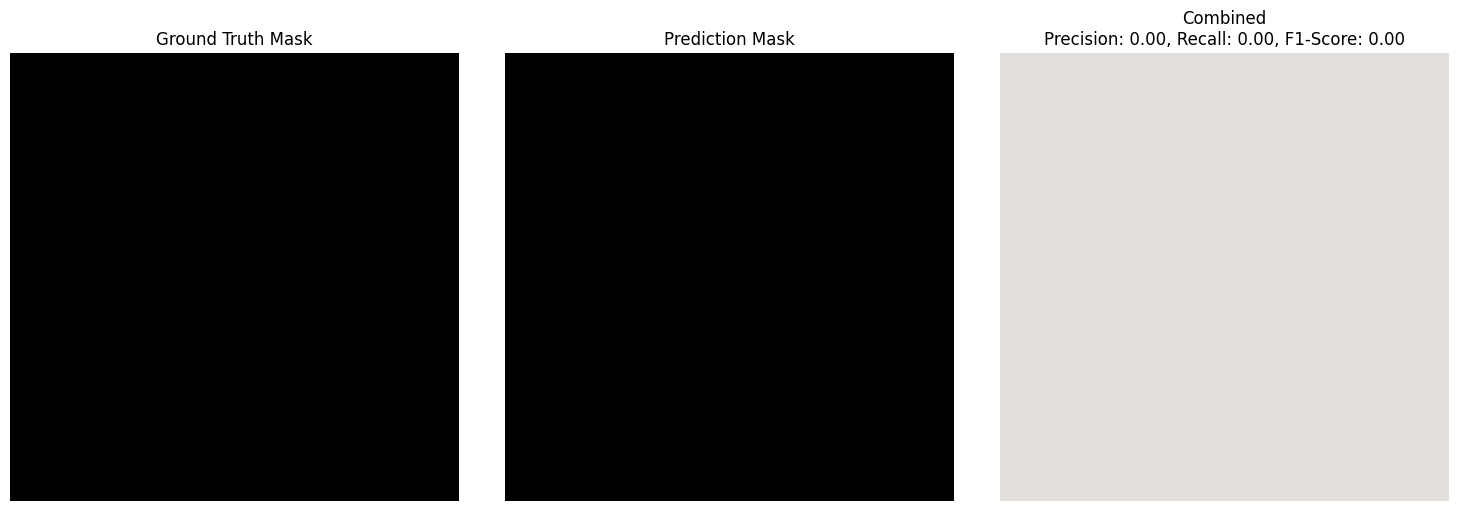

In [22]:
# import numpy as np
# import matplotlib.pyplot as plt

# def plot_masks_with_metrics(gt_masks, pred_masks, metrics):
#     """Plot each pair of ground truth and prediction masks with calculated metrics."""
#     num_masks = len(gt_masks)
#     if num_masks == 1:
#         fig, axes = plt.subplots(nrows=num_masks, ncols=3, figsize=(15, 5))
#         axes = np.array([axes])  # Convert to 2D array-like for consistent indexing
#     else:
#         fig, axes = plt.subplots(nrows=num_masks, ncols=3, figsize=(15, 5 * num_masks))

#     for i in range(num_masks):
#         gt_mask = gt_masks[i]
#         pred_mask = pred_masks[i]
#         precision, recall, f1_score = metrics[i]

#         # True Positive (Intersection)
#         tp_mask = np.logical_and(gt_mask == 1, pred_mask == 1)
#         # False Positive
#         fp_mask = np.logical_and(gt_mask == 0, pred_mask == 1)
#         # False Negative
#         fn_mask = np.logical_and(gt_mask == 1, pred_mask == 0)

#         # Plotting ground truth mask
#         axes[i][0].imshow(gt_mask, cmap='gray')
#         axes[i][0].set_title('Ground Truth Mask')
#         axes[i][0].axis('off')

#         # Plotting prediction mask
#         axes[i][1].imshow(pred_mask, cmap='gray')
#         axes[i][1].set_title('Prediction Mask')
#         axes[i][1].axis('off')

#         # Plotting combined mask with TP, FP, FN
#         axes[i][2].imshow(gt_mask, cmap='gray', alpha=0.5)  # Ground truth in gray
#         axes[i][2].imshow(pred_mask, cmap='hot', alpha=0.5)  # Prediction in hot color map
#         # Highlight TP, FP, FN
#         axes[i][2].imshow(tp_mask, cmap='Greens', alpha=0.5)  # True Positives in green
#         axes[i][2].imshow(fp_mask, cmap='Blues', alpha=0.5)  # False Positives in blue
#         axes[i][2].imshow(fn_mask, cmap='Reds', alpha=0.5)  # False Negatives in red
#         axes[i][2].set_title(f'Combined\nPrecision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1_score:.2f}')
#         axes[i][2].axis('off')

#     plt.tight_layout()
#     plt.show()

# # Example call (assuming pred_masks, gt_masks, and metrics have been defined earlier in your script)
# plot_masks_with_metrics(gt_masks, pred_masks, metrics)
